<a href="https://colab.research.google.com/github/DamnScallion/Agents-Demo/blob/main/Agent_Demo_4_LangGraph_multi_agent_collaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-agent network

A single agent can usually operate effectively using a handful of tools within a single domain, but even using powerful models like `gpt-4`, it can be less effective at using many tools.

One way to approach complicated tasks is through a "divide-and-conquer" approach: create a specialized agent for each task or domain and route tasks to the correct "expert". This is an example of a [multi-agent network](https://langchain-ai.github.io/langgraph/concepts/multi_agent/#network) architecture.

This notebook (inspired by the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155), by Wu, et. al.) shows one way to do this using LangGraph.

Before we get started, a quick note: this and other multi-agent notebooks are designed to show _how_ you can implement certain design patterns in LangGraph. If the pattern suits your needs, we recommend combining it with some of the other fundamental patterns described elsewhere in the docs for best performance.

## Setup

First, let's install our required packages and set our API keys:

In [ ]:
%%capture --no-stderr
%pip install -U langchain_community langchain_anthropic langchain_experimental matplotlib langgraph gradio

In [ ]:
# Set API keys: Claude and TAVILY \
import os
os.environ["ANTHROPIC_API_KEY"] = "REPLACE THIS STRING WITH YOUR OWN API KEY"
os.environ["TAVILY_API_KEY"] = "REPLACE THIS STRING WITH YOUR OWN API KEY"

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>.
    </p>
</div>

## Define tools

We will also define some tools that our agents will use in the future

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

# Initialize the Tavily search tool (for performing web searches)
search_tool = TavilySearchResults(max_results=5)

# Initialize the Python REPL tool (for executing Python code locally)
python_tool = PythonREPL()

# Define a tool to execute Python code using the Python REPL
@tool
def run_python_tool(code):
    """Run the given Python code and return its output."""
    result = python_tool.run(code)
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"

## Create graph

Now that we've defined our tools and made some helper functions, will create the individual agents below and tell them how to talk to each other using LangGraph.

### Define Agent Nodes

We now need to define the nodes.

First, we'll create a utility to create a system prompt for each agent.

In [ ]:
def system_prompt(suffix) :
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [ ]:
from typing import Literal

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_anthropic import ChatAnthropic
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command


llm = ChatAnthropic(model="claude-3-5-sonnet-latest")


def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto


# Research agent and node
research_agent = create_react_agent(
    llm,
    tools=[search_tool],
    prompt = system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
)


def research_node(state: MessagesState,) -> Command[Literal["chart_generator", END]]:
    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")
    # wrap in a human message, as not all providers allow, AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )


# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [run_python_tool],
    prompt= system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)


def chart_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")
    # wrap in a human message, as not all providers allow, AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

### Define the Graph

We can now put it all together and define the graph!

In [ ]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
graph = workflow.compile()

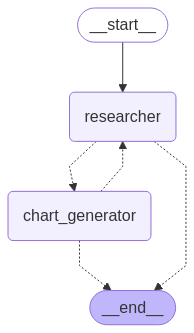

In [ ]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


## Invoke

With the graph created, you can invoke it! Let's have it chart some stats for us.

{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='e8ef3d54-0c56-40f5-8e67-ac825de9403c'), AIMessage(content=[{'text': "I'll help research the UK's GDP data for the past 5 years. Let me search for this information.", 'type': 'text'}, {'id': 'toolu_01BB7dPTrUJLszQWvfjM2cTJ', 'input': {'query': 'UK GDP annual data past 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Adg957WLSPiJ4Xi1vXjZsa', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 555, 'output_tokens': 91}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-f1f984bb-10b1-41c0-99ee-c8d171423be1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'U

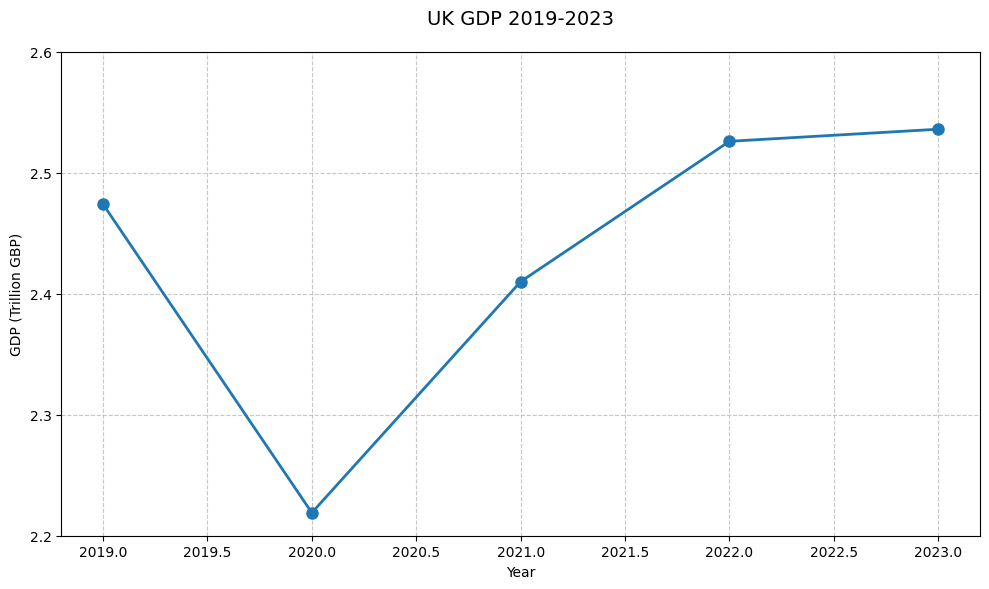

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it. Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='e8ef3d54-0c56-40f5-8e67-ac825de9403c'), AIMessage(content=[{'text': "I'll help research the UK's GDP data for the past 5 years. Let me search for this information.", 'type': 'text'}, {'id': 'toolu_01BB7dPTrUJLszQWvfjM2cTJ', 'input': {'query': 'UK GDP annual data past 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01Adg957WLSPiJ4Xi1vXjZsa', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 555, 'output_tokens': 91}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-f1f984bb-10b1-41c0-99ee-c8d171423be1-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query

In [ ]:
events = graph.stream(
    {
        "messages": [
            (
                "user",
                "First, get the UK's GDP over the past 5 years, then make a line chart of it. "
                "Once you make the chart, finish.",
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 150},
)
for s in events:
    print(s)
    print("----")

Enter your request: First, get the UK's GDP over the past 5 years, then make a line chart of it.  Once you make the chart, finish.
{'researcher': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it.  Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='0cbc618c-2d26-4c26-a827-5c8eaf7cc089'), AIMessage(content=[{'text': "I'll help search for the UK's GDP data over the past 5 years. Then my colleague can help create the line chart.", 'type': 'text'}, {'id': 'toolu_017wBDYPraJSTfRbydZPF6bW', 'input': {'query': 'UK GDP annual data last 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01SkawD5fa3WAbuPCyVvusDZ', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 556, 'output_tokens': 95}, 'model_name': 'c

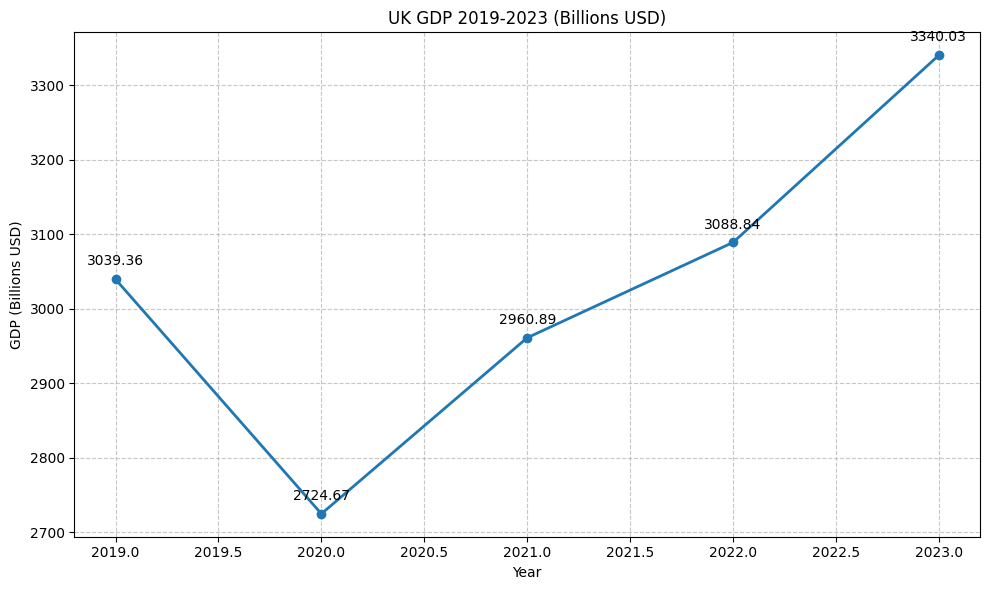

{'chart_generator': {'messages': [HumanMessage(content="First, get the UK's GDP over the past 5 years, then make a line chart of it.  Once you make the chart, finish.", additional_kwargs={}, response_metadata={}, id='0cbc618c-2d26-4c26-a827-5c8eaf7cc089'), AIMessage(content=[{'text': "I'll help search for the UK's GDP data over the past 5 years. Then my colleague can help create the line chart.", 'type': 'text'}, {'id': 'toolu_017wBDYPraJSTfRbydZPF6bW', 'input': {'query': 'UK GDP annual data last 5 years'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01SkawD5fa3WAbuPCyVvusDZ', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 556, 'output_tokens': 95}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run-fa3aaaac-f247-4a04-a5c2-4e8faf13c3e9-0', tool_calls=[{'name': 'tavily_search_results_json

In [ ]:
# Ask for user input in the notebook: First, get the Australia's GDP over the past 2 years, then make a line chart of it. Once you make the chart, finish.
user_query = input("Enter your request: ")

# Stream events through the graph
events = graph.stream(
    {
        "messages": [("user", user_query)],
    },
    {"recursion_limit": 150},
)

# Print each event step-by-step
for s in events:
    print(s)
    print("----")
